# k-Means Clustering for numerical features

In [16]:
import pandas as pd
import networkx as nx

In [17]:
df_posts = pd.read_json('../data/dataset.json')

In [18]:
df_posts['timestamp'] = pd.to_datetime(df_posts['timestamp'])

## Extract numeric features

### Temporal features

Number of posts over time

In [19]:
df_posts['posts_per_user'] = df_posts.groupby('user')['timestamp'].count()

Time between consecutive posts

In [20]:
# Calculate the time difference between posts
df_posts['time_diff'] = df_posts.groupby('user')['timestamp'].diff()

# Convert time_diff to timedelta
df_posts['time_diff'] = pd.to_timedelta(df_posts['time_diff'], errors='coerce')

# Replace NaT with the median time difference
df_posts['time_diff'] = df_posts['time_diff'].fillna(df_posts['time_diff'].median())

In [21]:
# Convert time_diff to seconds
df_posts['time_diff_seconds'] = df_posts['time_diff'].dt.total_seconds()

# Drop the time_diff column
df_posts = df_posts.drop(columns=['time_diff'])

### Text-based features

Tweet length

In [22]:
df_posts['text_length'] = df_posts['text'].apply(len)

Word count

In [23]:
df_posts['word_count'] = df_posts['text'].apply(lambda x: len(x.split()))

Sentiment Analysis score

In [24]:
sentiment_df = pd.read_csv('../output/sentiment.csv')

sentiment_subset = sentiment_df[['text_id', 'sentiment_score']]

df_posts = pd.merge(df_posts, sentiment_subset, on='text_id', how='left')

Hashtag count

In [25]:
df_posts['hashtag_count'] = df_posts['text'].str.count('#')

Topics from BERTopic

In [26]:
topics_df = pd.read_csv('../output/posts_with_topics.csv')

# Select only 'text_id' and 'topic_label' from topics_df
topics_subset = topics_df[['text_id', 'topic', 'topic_label']]

# Merge df_posts with the topics_subset on 'text_id'
df_posts = pd.merge(df_posts, topics_subset, on='text_id', how='left')

### Network Features

Follower count

In [27]:
# Load data
edges = pd.read_csv('../data/graph.csv')

# Create a graph
G = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr='weight')

# Calculate degrees
degrees = dict(G.degree())
degree_df = pd.DataFrame(degrees.items(), columns=['user_id', 'degree'])

Clustering Coefficient (how connected a user's neighbors are in the network)

In [28]:
clustering_coeff = nx.clustering(G)
clustering_df = pd.DataFrame(clustering_coeff.items(), columns=['user_id', 'clustering_coeff'])

Influence Score

In [29]:
pagerank = nx.pagerank(G)
pagerank_df = pd.DataFrame(pagerank.items(), columns=['user_id', 'pagerank'])

Betweenness Centrality

### Aggregate Features per User

Average Post Sentiment Per User

In [30]:
df_posts['avg_sentiment'] = df_posts.groupby('user_id')['sentiment_score'].transform('mean')

Variability in Posting Times

In [31]:
time_std = df_posts.groupby('user_id')['timestamp'].std().reset_index(name='time_std')

# Sentiment by Topic

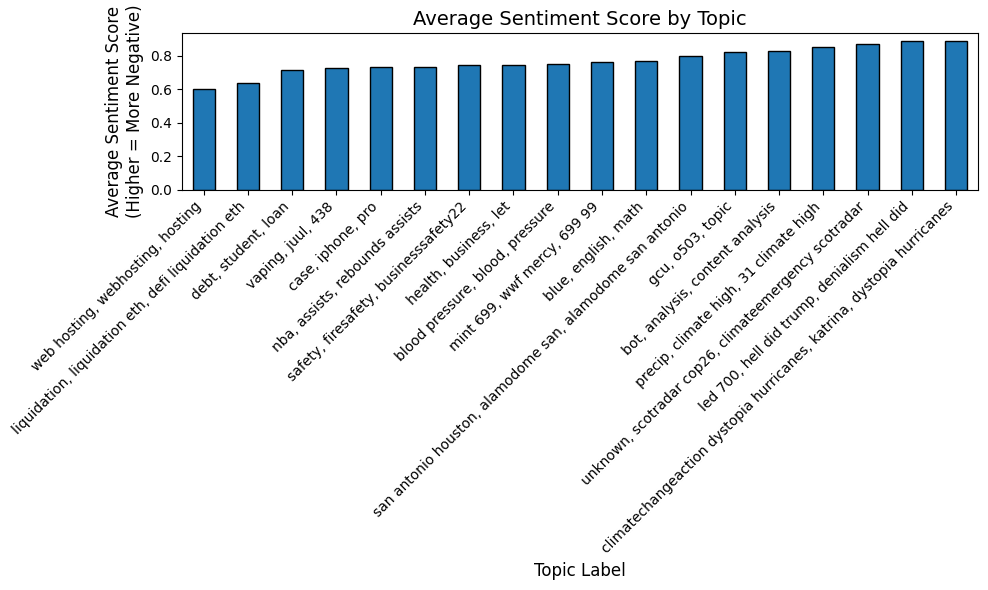

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by topic_label and calculate the mean sentiment score
topic_sentiment = df_posts.groupby('topic_label')['sentiment_score'].mean().sort_values()

plt.figure(figsize=(10, 6))
topic_sentiment.plot(kind='bar', edgecolor='black')
plt.title('Average Sentiment Score by Topic', fontsize=14)
plt.xlabel('Topic Label', fontsize=12)
plt.ylabel('Average Sentiment Score\n(Higher = More Negative)', fontsize=12)  # Added a line break
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

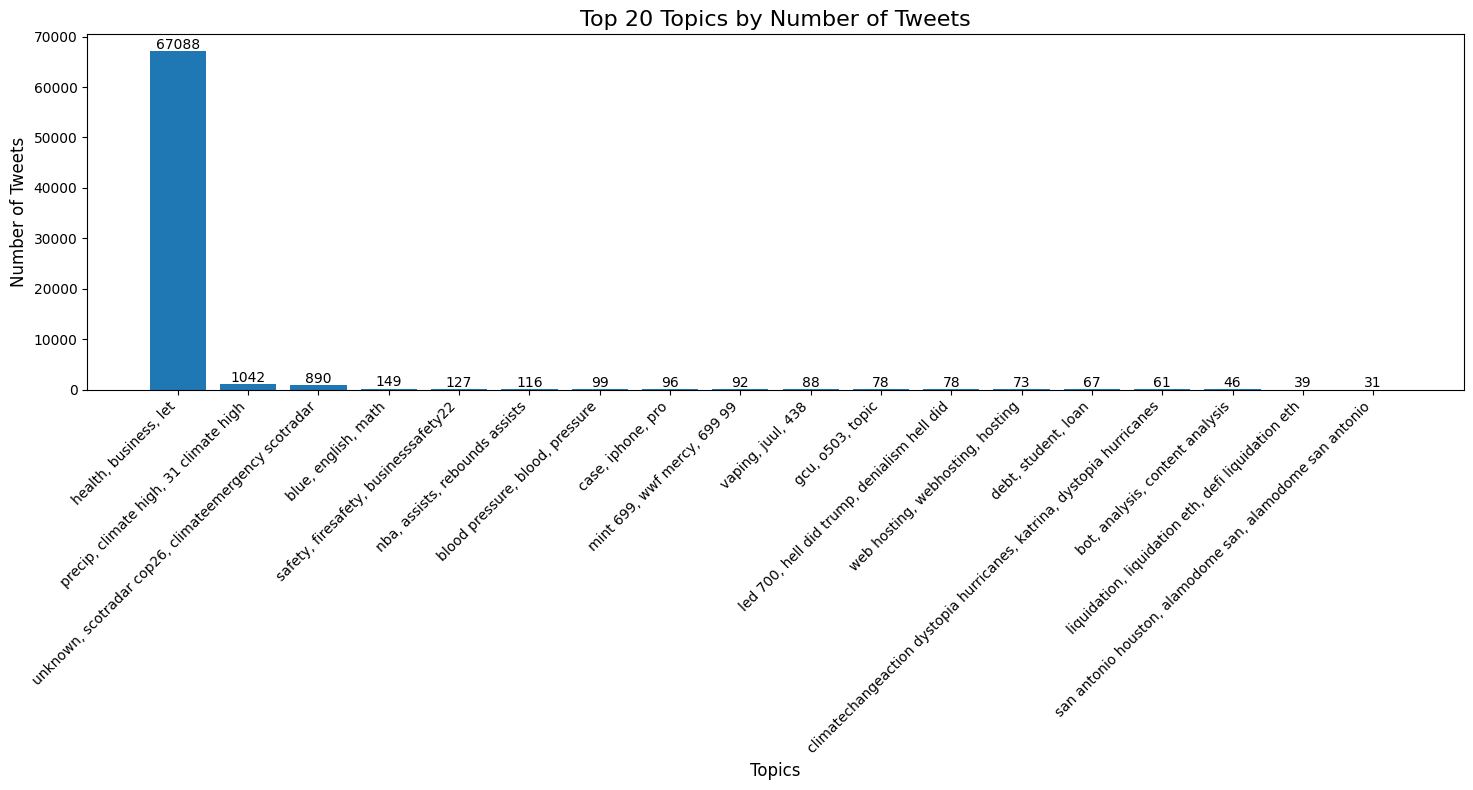

In [33]:
import matplotlib.pyplot as plt

# Assuming `df_posts` and other data manipulation remains the same
topic_counts = df_posts.groupby('topic_label').size().reset_index(name='tweet_count')
top_topics = topic_counts.sort_values(by='tweet_count', ascending=False).head(20)

plt.figure(figsize=(15, 8))  # Increase figure size
bars = plt.bar(top_topics['topic_label'], top_topics['tweet_count'])

# Add title and labels
plt.title('Top 20 Topics by Number of Tweets', fontsize=16)
plt.xlabel('Topics', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Add data labels on top of bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,  # Offset height slightly for visibility
             str(bar.get_height()), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Combined Features

Posting Behavior + Text Content: How does sentiment correlate with posting frequency or time?

Network + Text Analysis: Do influential users post more positive content?

## Normalize features

Merge Dataframe

In [34]:
# Merge the other dataframes onto df_posts
df_posts = df_posts.merge(degree_df, on="user_id", how="left")
df_posts = df_posts.merge(clustering_df, on="user_id", how="left")
df_posts = df_posts.merge(pagerank_df, on="user_id", how="left")

print(df_posts)

                timestamp                                               text  \
0     2024-10-31 00:00:00  Running a business means juggling countless ad...   
1     2024-10-31 00:00:00  Liz Truss is walking in the lingering shadow o...   
2     2024-10-31 00:00:00  The UK is bracing for war as government buildi...   
3     2024-10-31 00:00:00  Marrying a second or third cousin once removed...   
4     2024-10-31 00:00:00  It's truly disgraceful how the Indian National...   
...                   ...                                                ...   
70255 2024-10-31 23:59:52  @bakerjulie: "Saranghae, I’m your resident K-P...   
70256 2024-10-31 23:59:52  Soaring to new heights with @sweeneyanthony! T...   
70257 2024-10-31 23:59:54  Hey @james20 @paul47, did you see the latest f...   
70258 2024-10-31 23:59:58  Check out the fundraiser exhibition by @joanna...   
70259 2024-10-31 23:59:59  The appointment of Rees Mogg as business secre...   

          text_id              user    

- Normalize derived numerical features for clustering 
- Use features for clustering(k-Means or hierarchical)